<a href="https://colab.research.google.com/github/ayeeshasoudagar/GitTraining/blob/main/DL_Recommendation_system_zomato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayeesha07","key":"e0bc1e5899acf9d2962d6679dff96ef2"}'}

In [ ]:
#create a kaggle folder
!mkdir ~/.kaggle

In [ ]:
#copy the kaggle.json to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
#permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#to list all datasets in kaggle
! kaggle datasets list

ref                                                      title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                           Apple Quality                               170KB  2024-01-11 14:31:07           3709         93  1.0              
hummaamqaasim/jobs-in-data                               Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32          10018        197  1.0              
fekihmea/sales-store-overview                            Sales Store overview                          2KB  2024-01-20 11:10:10            903         25  1.0              
shashwatwork/depression-and-mental-health-data-analysis  Depression and Mental Health Data Analysis    7KB  2024-01-14 16:24:08        

In [ ]:
!kaggle datasets download -d absin7/zomato-bangalore-dataset

 98% 87.0M/89.0M [00:00<00:00, 106MB/s] 
100% 89.0M/89.0M [00:00<00:00, 97.5MB/s]


In [ ]:
!unzip zomato-bangalore-dataset.zip

Archive:  zomato-bangalore-dataset.zip
  inflating: dictionary_data.txt     
  inflating: zomato.csv              


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
zomato_real=pd.read_csv("/content/zomato.csv")

In [15]:
zomato_real.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [16]:
#Deleting Unnnecessary Columns
zomato=zomato_real.drop(['url','dish_liked','phone'],axis=1) #Dropping the column "dish_liked", "phone", "url" and saving the new dataset as "zomato"

#Removing the Duplicates
zomato.duplicated().sum()
zomato.drop_duplicates(inplace=True)

#Remove the NaN values from the dataset
zomato.isnull().sum()
zomato.dropna(how='any',inplace=True)

#Changing the column names
zomato = zomato.rename(columns={'approx_cost(for two people)':'cost','listed_in(type)':'type', 'listed_in(city)':'city'})

#Some Transformations
zomato['cost'] = zomato['cost'].astype(str) #Changing the cost to string
zomato['cost'] = zomato['cost'].apply(lambda x: x.replace(',','.')) #Using lambda function to replace ',' from cost
zomato['cost'] = zomato['cost'].astype(float)
#Removing '/5' from Rates
zomato = zomato.loc[zomato.rate !='NEW']
zomato = zomato.loc[zomato.rate !='-'].reset_index(drop=True)
remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
zomato.rate = zomato.rate.apply(remove_slash).str.strip().astype('float')

# Adjust the column names
zomato.name = zomato.name.apply(lambda x:x.title())
zomato.online_order.replace(('Yes','No'),(True, False),inplace=True)
zomato.book_table.replace(('Yes','No'),(True, False),inplace=True)

## Computing Mean Rating
restaurants = list(zomato['name'].unique())
zomato['Mean Rating'] = 0

for i in range(len(restaurants)):
    zomato['Mean Rating'][zomato['name'] == restaurants[i]] = zomato['rate'][zomato['name'] == restaurants[i]].mean()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (1,5))
zomato[['Mean Rating']] = scaler.fit_transform(zomato[['Mean Rating']]).round(2)

<ipython-input-16-2f0bffd8832b>:22: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  remove_slash = lambda x: x.replace('/5', '') if type(x) == np.str else x
<ipython-input-16-2f0bffd8832b>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zomato['Mean Rating'][zomato['name'] == restaurants[i]] = zomato['rate'][zomato['name'] == restaurants[i]].mean()


In [17]:
zomato

,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,reviews_list,menu_item,type,city,Mean Rating
0,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,True,True,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,3.99
1,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,True,False,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,3.97
2,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,True,False,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,3.58
3,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,False,False,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,3.45
4,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,False,False,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,3.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41232,"136, SAP Labs India, KIADB Export Promotion In...",The Farm House Bar N Grill,False,False,3.7,34,Whitefield,"Casual Dining, Bar","North Indian, Continental",800.0,"[('Rated 4.0', 'RATED\n Ambience- Big and spa...",[],Pubs and bars,Whitefield,3.45
41233,"139/C1, Next To GR Tech Park, Pattandur Agraha...",Bhagini,False,False,2.5,81,Whitefield,"Casual Dining, Bar","Andhra, South Indian, Chinese, North Indian",800.0,"[('Rated 4.0', 'RATED\n A fine place to chill...",[],Pubs and bars,Whitefield,1.62
41234,"Four Points by Sheraton Bengaluru, 43/3, White...",Best Brews - Four Points By Sheraton Bengaluru...,False,False,3.6,27,Whitefield,Bar,Continental,1.5,"[('Rated 5.0', ""RATED\n Food and service are ...",[],Pubs and bars,Whitefield,3.32
41235,Sheraton Grand Bengaluru Whitefield Hotel & Co...,Chime - Sheraton Grand Bengaluru Whitefield Ho...,False,True,4.3,236,"ITPL Main Road, Whitefield",Bar,Finger Food,2.5,"[('Rated 4.0', 'RATED\n Nice and friendly pla...",[],Pubs and bars,Whitefield,4.23


In [18]:
location= zomato.location.unique()
location

array(['Banashankari', 'Basavanagudi', 'Mysore Road', 'Jayanagar',
       'Kumaraswamy Layout', 'Rajarajeshwari Nagar', 'Vijay Nagar',
       'Uttarahalli', 'JP Nagar', 'South Bangalore', 'City Market',
       'Bannerghatta Road', 'BTM', 'Kanakapura Road', 'Bommanahalli',
       'Electronic City', 'Wilson Garden', 'Shanti Nagar',
       'Koramangala 5th Block', 'Richmond Road', 'HSR',
       'Koramangala 7th Block', 'Bellandur', 'Sarjapur Road',
       'Marathahalli', 'Whitefield', 'East Bangalore', 'Old Airport Road',
       'Indiranagar', 'Koramangala 1st Block', 'Frazer Town', 'MG Road',
       'Brigade Road', 'Lavelle Road', 'Church Street', 'Ulsoor',
       'Residency Road', 'Shivajinagar', 'Infantry Road',
       'St. Marks Road', 'Cunningham Road', 'Race Course Road',
       'Commercial Street', 'Vasanth Nagar', 'Domlur',
       'Koramangala 8th Block', 'Ejipura', 'Jeevan Bhima Nagar',
       'Old Madras Road', 'Seshadripuram', 'Kammanahalli',
       'Koramangala 6th Block', 'Ma

In [19]:
zomato.corr(method ='spearman')

<ipython-input-19-538400eebefd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  zomato.corr(method ='spearman')


,online_order,book_table,rate,votes,cost,Mean Rating
online_order,1.000000,-0.054894,0.078493,0.159838,0.180865,0.070927
book_table,-0.054894,1.000000,0.446018,0.466304,-0.259121,0.452280
rate,0.078493,0.446018,1.000000,0.700950,-0.090199,0.946522
votes,0.159838,0.466304,0.700950,1.000000,0.027004,0.670111
cost,0.180865,-0.259121,-0.090199,0.027004,1.000000,-0.094218
Mean Rating,0.070927,0.452280,0.946522,0.670111,-0.094218,1.000000


In [20]:
mk=zomato.corr(method ='kendall')
mk

<ipython-input-20-88857e899819>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mk=zomato.corr(method ='kendall')


,online_order,book_table,rate,votes,cost,Mean Rating
online_order,1.000000,-0.054894,0.066107,0.130885,0.152519,0.058549
book_table,-0.054894,1.000000,0.375637,0.381838,-0.218509,0.373346
rate,0.066107,0.375637,1.000000,0.534326,-0.060617,0.864688
votes,0.130885,0.381838,0.534326,1.000000,0.033517,0.494741
cost,0.152519,-0.218509,-0.060617,0.033517,1.000000,-0.061348
Mean Rating,0.058549,0.373346,0.864688,0.494741,-0.061348,1.000000


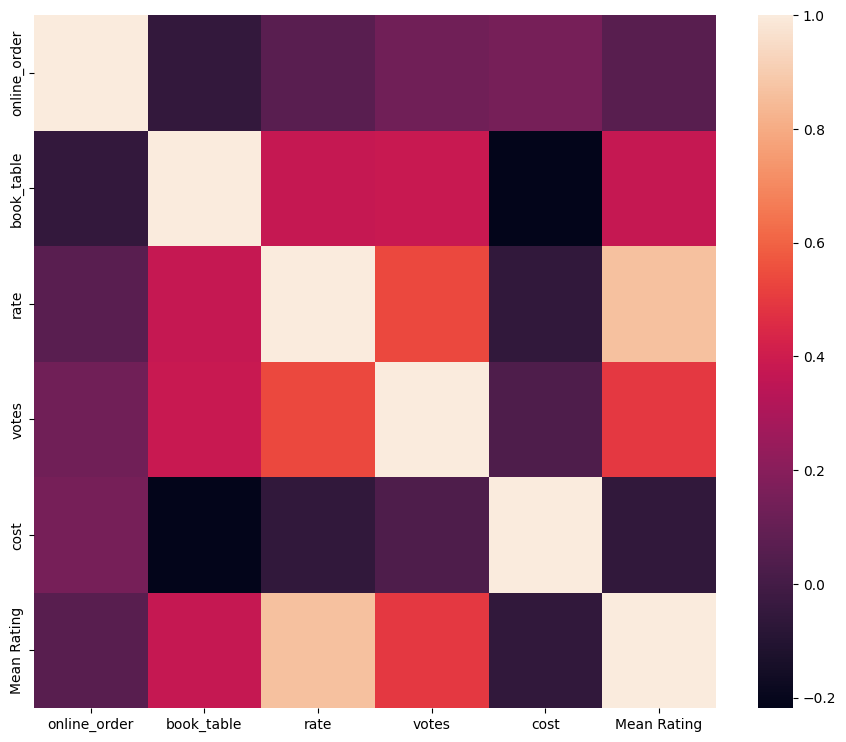

In [21]:
fig, ax = plt.subplots(figsize=(11, 9))
sb.heatmap(mk)
plt.show()

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
zomato["reviews_list"] = zomato["reviews_list"].str.lower()

## Removal of Puctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_punctuation(text))

## Removal of Stopwords
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_stopwords(text))

## Removal of URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

zomato["reviews_list"] = zomato["reviews_list"].apply(lambda text: remove_urls(text))

zomato[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
36532,rated 30 ratedn little italys quality definite...,"Italian, Pizza, Mexican"
6287,rated 30 ratedn ambience small diner outside s...,"North Indian, Chinese, Rolls"
29630,rated 40 ratedn itãx83ãx83ãx82ãx83ãx83ãx...,Kerala
18576,rated 30 ratedn went sunday night beer hop unf...,"Chinese, South Indian, North Indian"
27026,rated 20 ratedn went recently dinner buffet fr...,"European, Asian"


In [24]:
restaurant_names = list(zomato['name'].unique())
def get_top_words(column, top_nu_of_words, nu_of_word):
    vec = CountVectorizer(ngram_range= nu_of_word, stop_words='english')
    bag_of_words = vec.fit_transform(column)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_nu_of_words]

zomato=zomato.drop(['address','rest_type', 'type', 'menu_item', 'votes'],axis=1)
import pandas

# Randomly sample 60% of your dataframe
df_percent = zomato.sample(frac=0.5)

In [25]:
df_percent

,name,online_order,book_table,rate,location,cuisines,cost,reviews_list,city,Mean Rating
25091,Black Cup Cafe,True,False,3.7,BTM,"Cafe, Fast Food, Beverages",400.0,rated 10 ratedn went ratings placed order chic...,Koramangala 5th Block,3.42
15084,Sri Lakshmi Darshini,False,False,3.4,Thippasandra,"South Indian, North Indian",150.0,rated 40 ratedn right place special masala dos...,Indiranagar,3.06
25786,Sweet Truth,True,False,4.2,Koramangala 8th Block,"Bakery, Desserts",500.0,rated 40 ratedn review based review programnn1...,Koramangala 6th Block,3.77
32325,Bitebox,True,False,4.5,Marathahalli,"North Indian, Chinese, Mughlai, Desserts",300.0,rated 50 ratedn bitebox perfect food hub servi...,Marathahalli,4.44
21030,Chettayees,True,False,3.4,BTM,"Kerala, North Indian, Chinese",400.0,rated 20 ratedn pothichoru chettayees disaster...,Koramangala 4th Block,3.06
...,...,...,...,...,...,...,...,...,...,...
22917,Tawa Ghar Ka,True,False,3.8,HSR,North Indian,350.0,rated 40 ratedn crowded place lunch hour much ...,Koramangala 4th Block,3.58
40055,Starbucks,False,False,3.9,Whitefield,"Cafe, Desserts",700.0,rated 50 ratedn love signature hot chocolate s...,Whitefield,3.84
26657,Eat.Fit,True,False,4.6,Koramangala 5th Block,"Healthy Food, North Indian, Biryani, Continent...",500.0,rated 50 ratedn eatfit preferred outlet order ...,Koramangala 6th Block,4.33
28764,New Farm Fresh,False,False,3.6,BTM,"Italian, Pizza",650.0,rated 35 ratedn tried grilled prawns pizza tas...,Koramangala 7th Block,3.32


In [26]:
with open('df_percent.csv', 'w', encoding='utf-8') as f:
    df_percent.to_csv(f)

In [27]:
from sklearn.metrics.pairwise import linear_kernel

df_percent.set_index('name', inplace=True)
indices = pd.Series(df_percent.index)

# Creating tf-idf matrix
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [28]:
def recommend(name, cosine_similarities = cosine_similarities):

    # Create a list to put top restaurants
    recommend_restaurant = []

    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)

    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])

    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost'])

    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))

    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)
    df_new['name'] = df_new.index
    df_new = df_new.reset_index(drop=True)[['name', 'cuisines', 'Mean Rating', 'cost']]

    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))

    return df_new

df_new2= recommend('Fast And Fresh')

TOP 10 RESTAURANTS LIKE Fast And Fresh WITH SIMILAR REVIEWS: 


<ipython-input-28-0dd255bdaca1>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-28-0dd255bdaca1>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-28-0dd255bdaca1>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-28-0dd255bdaca1>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [29]:
df_new2

,name,cuisines,Mean Rating,cost
0,Pallavi Restaurant,"Biryani, Chinese, Andhra",3.58,500.0
1,Four Seasons Fast Food Center,"North Indian, Chinese, Biryani",3.49,400.0
2,Donne Biriyani Angadi Mane,"Biryani, Chinese",3.47,250.0
3,Sri Krishna Sagar,South Indian,3.26,300.0
4,Desi Dhaba,"North Indian, Chinese, Rolls",3.19,300.0
5,Konaseema Grand,"North Indian, Mughlai, Andhra, Biryani",2.87,1.0
6,Sri Lakshmi Dhaba,"North Indian, Chinese",2.50,300.0
7,Indian Food,"North Indian, Biryani, Chinese, Momos",2.42,450.0
8,Biryani Feast,"Biryani, North Indian, Chinese",2.42,600.0
9,Night Food Joint,"North Indian, Chinese",2.35,500.0


In [30]:
pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255317 sha256=f55045049890e78a2e53ba93719365fb6d4c29f9b3f8695e1c4c775cbb739687
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5


In [31]:
import pickle

In [32]:
file = open("res.pkl", 'wb')
pickle.dump(df_new2, file)

In [33]:
df_new2.to_dict()

{'name': {0: 'Pallavi Restaurant',
  1: 'Four Seasons Fast Food Center',
  2: 'Donne Biriyani Angadi Mane',
  3: 'Sri Krishna Sagar',
  4: 'Desi Dhaba',
  5: 'Konaseema Grand',
  6: 'Sri Lakshmi Dhaba',
  7: 'Indian Food',
  8: 'Biryani Feast',
  9: 'Night Food Joint'},
 'cuisines': {0: 'Biryani, Chinese, Andhra',
  1: 'North Indian, Chinese, Biryani',
  2: 'Biryani, Chinese',
  3: 'South Indian',
  4: 'North Indian, Chinese, Rolls',
  5: 'North Indian, Mughlai, Andhra, Biryani',
  6: 'North Indian, Chinese',
  7: 'North Indian, Biryani, Chinese, Momos',
  8: 'Biryani, North Indian, Chinese',
  9: 'North Indian, Chinese'},
 'Mean Rating': {0: 3.58,
  1: 3.49,
  2: 3.47,
  3: 3.26,
  4: 3.19,
  5: 2.87,
  6: 2.5,
  7: 2.42,
  8: 2.42,
  9: 2.35},
 'cost': {0: 500.0,
  1: 400.0,
  2: 250.0,
  3: 300.0,
  4: 300.0,
  5: 1.0,
  6: 300.0,
  7: 450.0,
  8: 600.0,
  9: 500.0}}

In [34]:
def recommend(name, cosine_similarities = cosine_similarities):

    # Create a list to put top restaurants
    recommend_restaurant = []

    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)

    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])

    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost'])

    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))

    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)

    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))

    return df_new
recommend('Pai Vihar')

TOP 10 RESTAURANTS LIKE Pai Vihar WITH SIMILAR REVIEWS: 


<ipython-input-34-235d686c483f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-34-235d686c483f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-34-235d686c483f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-34-235d686c483f>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

,cuisines,Mean Rating,cost
Burma Burma,"Asian, Burmese",4.74,1.5
Chianti,Italian,4.59,1.5
Lavonne,"Cafe, Desserts",4.35,800.0
Little Green Cafe,"Cafe, Healthy Food, Salad, Continental, Bevera...",4.23,900.0
Nando'S,"Portuguese, Wraps, Burger, Salad",4.13,1.2
Marzipan Cafe & Bakery,"Cafe, Mediterranean, Bakery, Greek, Beverages",4.10,700.0
Ilyazsab The House Of Chicken,"Rolls, Kebab",3.84,250.0
Dum Biryani Hub,Biryani,3.71,700.0
1992 Chats - Space,Street Food,3.45,200.0
Karavali Grand,"Mangalorean, Seafood, North Indian, Chinese",3.45,600.0


In [46]:
def recommend(name, cosine_similarities = cosine_similarities):

    # Create a list to put top restaurants
    recommend_restaurant = []

    # Find the index of the hotel entered
    idx = indices[indices == name].index[0]

    # Find the restaurants with a similar cosine-sim value and order them from bigges number
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending=False)

    # Extract top 30 restaurant indexes with a similar cosine-sim value
    top30_indexes = list(score_series.iloc[0:31].index)

    # Names of the top 30 restaurants
    for each in top30_indexes:
        recommend_restaurant.append(list(df_percent.index)[each])

    # Creating the new data set to show similar restaurants
    df_new = pd.DataFrame(columns=['cuisines', 'Mean Rating', 'cost'])

    # Create the top 30 similar restaurants with some of their columns
    for each in recommend_restaurant:
        df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))

    # Drop the same named restaurants and sort only the top 10 by the highest rating
    df_new = df_new.drop_duplicates(subset=['cuisines','Mean Rating', 'cost'], keep=False)
    df_new = df_new.sort_values(by='Mean Rating', ascending=False).head(10)

    print('TOP %s RESTAURANTS LIKE %s WITH SIMILAR REVIEWS: ' % (str(len(df_new)), name))

    return df_new
recommend('Behrouz Biryani')

TOP 7 RESTAURANTS LIKE Behrouz Biryani WITH SIMILAR REVIEWS: 


<ipython-input-46-9647e8a74ceb>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-46-9647e8a74ceb>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-46-9647e8a74ceb>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(pd.DataFrame(df_percent[['cuisines','Mean Rating', 'cost']][df_percent.index == each].sample()))
<ipython-input-46-9647e8a74ceb>:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

,cuisines,Mean Rating,cost
Meghana Foods,North Indian,4.28,800.0
Meghana Foods,"Biryani, Seafood, Andhra, North Indian",4.28,600.0
Potful,"Biryani, Kebab, Rolls, Mughlai",3.82,650.0
Mani'S Dum Biryani,Biryani,3.77,750.0
Hyderabad Biryaani Home,"North Indian, Hyderabadi, Chinese",2.55,650.0
Ammi'S Biryani,"Biryani, North Indian",2.03,500.0
Ammi'S Biryani,"Biryani, North Indian",2.03,350.0
